# Tutorial 2: inferring a sample–cell matrix and reconstructing sample-specific single-cell transcriptomic profiles

CellFreeGMF traces the cellular origins of these cfRNA markers and elucidates their cell-specific alterations based on cell-free transcriptome and single-cell sequencing data.

## Preparation

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import anndata as ad
import scanpy as sc

In [2]:
import CellFreeGMF

## Hyperparameter Configuration

In [3]:
seed_value = 2025
disease_name = 'PDAC'
current_path = os.path.abspath('')

## Load the cfRNA transcriptome matrix

In [4]:
def read_sample_cfRNA(disease_name = 'PDAC'):

    data_path = current_path + '/data/' + disease_name

    data_exp = pd.read_csv(data_path + '/GSE133684_exp_TPM-all.txt', sep='\t')
    data_exp = data_exp.set_index(data_exp.columns[0]).T

    label_all = pd.read_csv(data_path + '/GSE133684_series_matrix.csv', sep=',')
    
    label_all = label_all.set_index(label_all.columns[0])
    label_all['label'] = label_all[label_all.columns[0]].apply(lambda x: 1 if x == 'disease state: PDAC' else 0)

    # label_all = label_all.loc[data_exp.index]
    data_exp = data_exp.loc[label_all.index]

    data_all = {'data_exp': data_exp,
                'label': label_all}

    return data_all

sample_cfRNA_exp = read_sample_cfRNA(disease_name)

exp_all = sample_cfRNA_exp['data_exp']
exp_all_label = sample_cfRNA_exp['label']['label']

## Load the references single-cell transcriptomic data

In [5]:
def read_scRNA():
    adata = ad.read_h5ad(current_path + '/data/TSP/TabulaSapiens.h5ad')
    adata.var.index = adata.var['ensemblid']

    if disease_name == 'pregnancy':
        adata = adata[adata.obs['gender'] != 'male'].copy()
        adata = adata[adata.obs['organ_tissue'] == 'Uterus'].copy()
    
    if disease_name == 'tuberculosis':
        adata = adata[adata.obs['organ_tissue'] == 'Lung'].copy()

    if disease_name == 'PDAC':
        adata = adata[adata.obs['organ_tissue'] == 'Pancreas'].copy()

    sc.pp.filter_genes(adata, min_cells=3)
    sc.pp.filter_cells(adata, min_genes=100)

    return adata

scRNA_adata = read_scRNA()

## Visualization of scRNA-seq Data

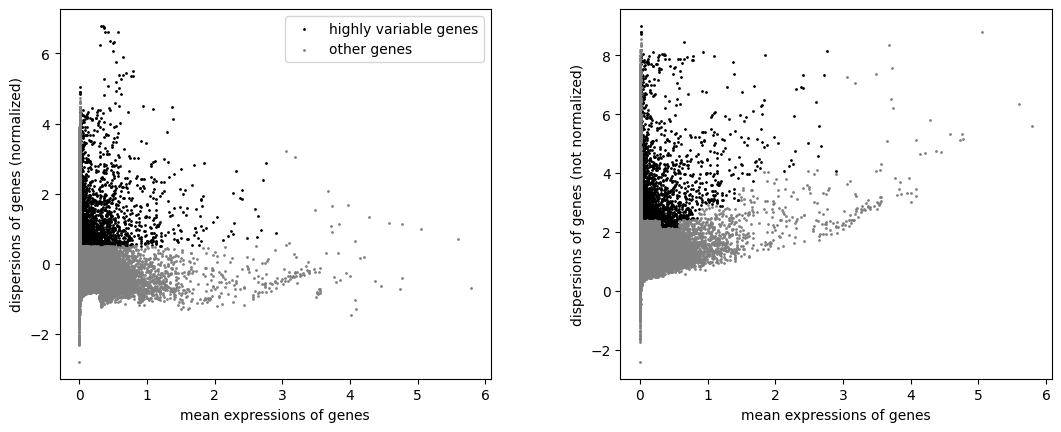

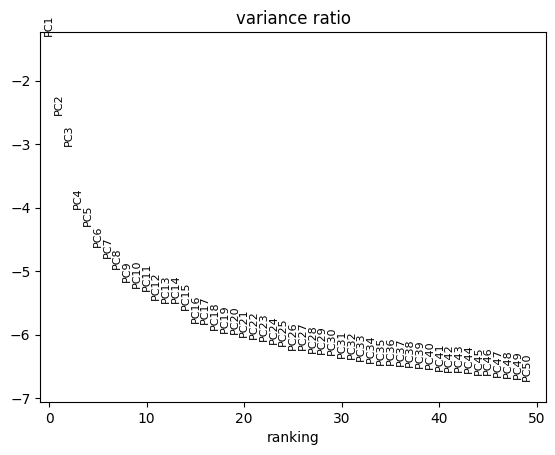

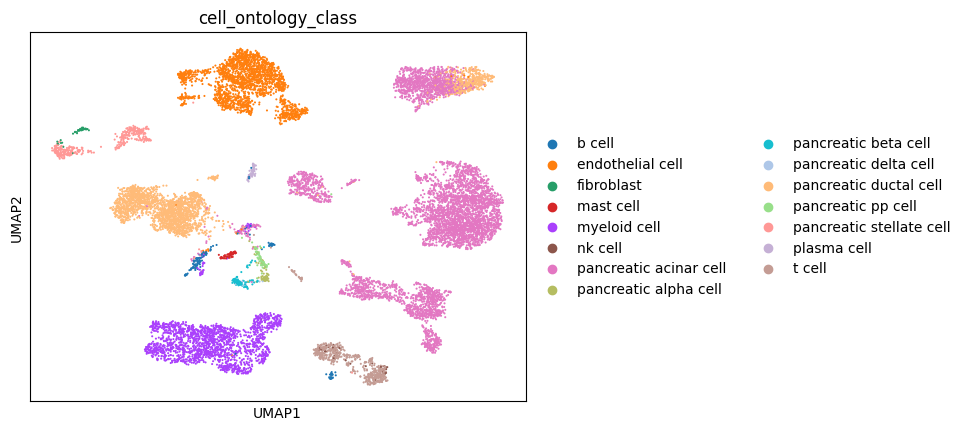

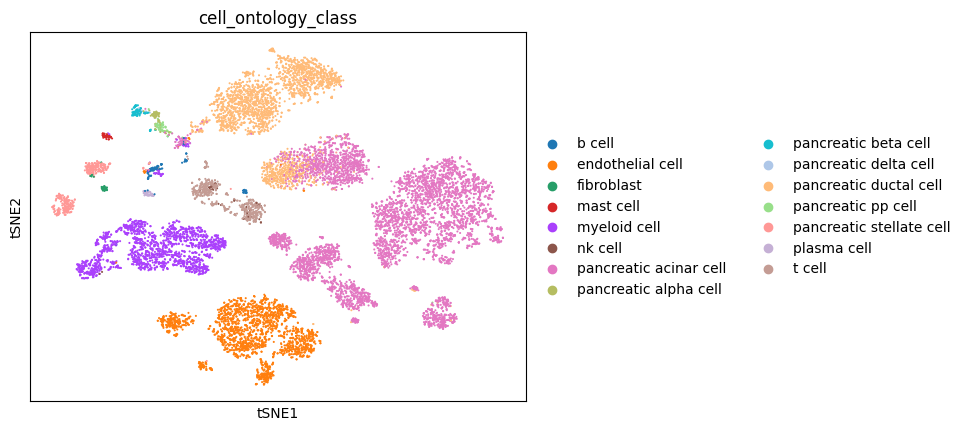

In [6]:
import copy
temp_sc = copy.deepcopy(scRNA_adata)

sc.pl.highly_variable_genes(temp_sc)

sc.tl.pca(temp_sc)

sc.pl.pca_variance_ratio(temp_sc, n_pcs=50, log=True)

sc.pp.neighbors(temp_sc)

sc.tl.umap(temp_sc)
sc.tl.tsne(temp_sc)

sc.pl.umap(temp_sc,
        color = 'cell_ontology_class',
        frameon = True,
        save = '_' + disease_name + '.pdf')

sc.pl.tsne(temp_sc,
        color = 'cell_ontology_class',
        frameon = True,
        save = '_' + disease_name + '.pdf')

## Target information was loaded for subsequent analysis.

In [7]:
SHAP_cfRNA = pd.read_csv(current_path + '/save_data/' + disease_name + '/SHAP_ALL_gene.txt', header=None)

DEG = pd.read_csv(current_path + '/save_data/' + disease_name + '/DEG_res.csv')
DEG = DEG.sort_values(by="logFC", key=lambda x: x.abs(), ascending=False)

In [8]:
sample_types = ['normal']
cfRNA_types = ['Target_gene']


for sample_type in sample_types:
    for cfRNA_type in cfRNA_types:
        if sample_type == 'normal':
            if cfRNA_type == 'Target_gene':
                target_cfRNA = set(SHAP_cfRNA.iloc[:,0].str.split('.').str[0].tolist()) | set(DEG.iloc[:, 0].str.split('.').str[0].tolist())
                sample_cfRNA_exp, cell_exp_adata = CellFreeGMF.filter_with_overlap_gene(exp_all[exp_all_label == 0][list(target_cfRNA)], scRNA_adata)
        elif sample_type == 'disease':
            if cfRNA_type == 'Target_gene':
                target_cfRNA = set(SHAP_cfRNA.iloc[:,0].str.split('.').str[0].tolist()) | set(DEG.iloc[:, 0].str.split('.').str[0].tolist())
                sample_cfRNA_exp, cell_exp_adata = CellFreeGMF.filter_with_overlap_gene(exp_all[exp_all_label == 1][list(target_cfRNA)], scRNA_adata)

        # starndard
        cell_exp_count = pd.DataFrame(data=cell_exp_adata.layers['raw_counts'].toarray(),
                                        index = cell_exp_adata.obs.index,
                                        columns= cell_exp_adata.var.index)   
        stand_cell_exp = CellFreeGMF.log_cpm(cell_exp_count).T
        stand_sample_exp = CellFreeGMF.log_cpm(sample_cfRNA_exp).T

        # calculate similarity
        cos_cell = cosine_similarity(stand_cell_exp)

Number of overlap genes: 8599


In [9]:
cos_cell.shape,stand_cell_exp.shape

((13497, 13497), (13497, 8599))

## inferring a sample–cell matrix and reconstructing sample-specific single-cell transcriptomic profiles

In [ ]:
sample_types = ['normal', 'disease']
cfRNA_types = ['Target_gene']


for sample_type in sample_types:
    for cfRNA_type in cfRNA_types:
        if sample_type == 'normal':
            if cfRNA_type == 'Target_gene':
                target_cfRNA = set(SHAP_cfRNA.iloc[:,0].str.split('.').str[0].tolist()) | set(DEG.iloc[:, 0].str.split('.').str[0].tolist())
                sample_cfRNA_exp, cell_exp_adata = CellFreeGMF.filter_with_overlap_gene(exp_all[exp_all_label == 0][list(target_cfRNA)], scRNA_adata)
        elif sample_type == 'disease':
            if cfRNA_type == 'Target_gene':
                target_cfRNA = set(SHAP_cfRNA.iloc[:,0].str.split('.').str[0].tolist()) | set(DEG.iloc[:, 0].str.split('.').str[0].tolist())
                sample_cfRNA_exp, cell_exp_adata = CellFreeGMF.filter_with_overlap_gene(exp_all[exp_all_label == 1][list(target_cfRNA)], scRNA_adata)

        # starndard
        cell_exp_count = pd.DataFrame(data=cell_exp_adata.layers['raw_counts'].toarray(),
                                        index = cell_exp_adata.obs.index,
                                        columns= cell_exp_adata.var.index)   
        stand_cell_exp = CellFreeGMF.log_cpm(cell_exp_count).T
        stand_sample_exp = CellFreeGMF.log_cpm(sample_cfRNA_exp).T

        # calculate similarity
        cos_sample = cosine_similarity(stand_sample_exp)
        
        row_id, col_id = np.diag_indices_from(cos_sample)
        cos_sample[row_id, col_id] = 0

        Sample_cell = np.random.rand(cos_sample.shape[0], stand_cell_exp.shape[0])
        
        Result_cfRNA_cell, Result_sample_cfRNA, Result_sample_cell = CellFreeGMF.GNMF(sample_cfRNA = stand_sample_exp.values,
                                                                                            cell_cfRNA = stand_cell_exp.values,
                                                                                            sample_sim = cos_sample,
                                                                                            beta = 0.001,
                                                                                            alpha = 0.001,
                                                                                            iter_num = 100)

        np.savez(file=current_path + '/save_data/' + disease_name + '/Decon_sampletype_' + sample_type + '_cfRNAtype_' + cfRNA_type + '.npz',
                Result_cfRNA_cell = Result_cfRNA_cell,
                Result_sample_cfRNA = Result_sample_cfRNA, 
                Result_sample_cell = Result_sample_cell,
                sample_name = stand_sample_exp.index,
                cfRNA_name = stand_sample_exp.columns,
                cell_name_free_annotation = cell_exp_adata.obs.free_annotation,
                cell_name_cell_ontology_class = cell_exp_adata.obs.cell_ontology_class,
                cell_id = stand_cell_exp.index,
                sample_cfRNA = stand_sample_exp.values,
                cell_cfRNA = stand_cell_exp.values)

Number of overlap genes: 8599
GNMF: step=10  obj=816104100.320847  error=1.023134
, last_error=1.023410
, ddd:  0.000276
GNMF: step=20  obj=759958024.195542  error=0.984385
, last_error=0.994942
, ddd:  0.010558
GNMF: step=30  obj=715348310.949574  error=0.909971
, last_error=0.913787
, ddd:  0.003816
GNMF: step=40  obj=701777906.458539  error=0.886454
, last_error=0.888091
, ddd:  0.001636
GNMF: step=50  obj=693960927.356656  error=0.874075
, last_error=0.875069
, ddd:  0.000994
GNMF: step=60  obj=688430543.474555  error=0.866155
, last_error=0.866797
, ddd:  0.000642
GNMF: step=70  obj=684460638.526017  error=0.860976
, last_error=0.861416
, ddd:  0.000440
GNMF: step=80  obj=681300919.284633  error=0.857189
, last_error=0.857525
, ddd:  0.000337
GNMF: step=90  obj=678704319.051207  error=0.854236
, last_error=0.854501
, ddd:  0.000265
GNMF: step=100  obj=676556170.742099  error=0.851878
, last_error=0.852092
, ddd:  0.000214
Number of overlap genes: 8599
GNMF: step=10  obj=812183263.